In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
#nltk.download('punkt')
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
from matplotlib import pyplot as plt
from sklearn.metrics import plot_precision_recall_curve
import numpy as np
from sklearn.model_selection import GridSearchCV

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\WW\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
df = pd.read_csv("labeled.csv", sep=",")

In [4]:
df.shape


(14412, 2)

In [5]:
df.head(5)

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0


In [6]:
df["toxic"] = df["toxic"].apply(int) # convert to integer


In [7]:
df.head(5)

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1
1,"Хохлы, это отдушина затюканого россиянина, мол...",1
2,Собаке - собачья смерть\n,1
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1


In [8]:
df["toxic"].value_counts()

0    9586
1    4826
Name: toxic, dtype: int64

In [9]:
for c in df[df["toxic"] == 1]["comment"].head(5):   # examples of toxic comments
    print(c)

Верблюдов-то за что? Дебилы, бл...

Хохлы, это отдушина затюканого россиянина, мол, вон, а у хохлов еще хуже. Если бы хохлов не было, кисель их бы придумал.

Собаке - собачья смерть

Страницу обнови, дебил. Это тоже не оскорбление, а доказанный факт - не-дебил про себя во множественном числе писать не будет. Или мы в тебя верим - это ты и твои воображаемые друзья?

тебя не убедил 6-страничный пдф в том, что Скрипалей отравила Россия? Анализировать и думать пытаешься? Ватник что ли?)



In [10]:
for c in df[df["toxic"] == 0]["comment"].head(5):  # examples of non-toxic comments
    print(c)


В шапке были ссылки на инфу по текущему фильму марвел. Эти ссылки были заменены на фразу Репортим брипидора, игнорируем его посты. Если этого недостаточно, чтобы понять, что модератор абсолютный неадекват, и его нужно лишить полномочий, тогда эта борда пробивает абсолютное дно по неадекватности.

Почитайте посты у этого автора,может найдете что нибудь полезное. Надеюсь помог) https: pikabu.ru story obyichnyie budni dezsluzhbyi 4932098

Про графику было обидно) я так то проходил все серии гта со второй части по пятую, кроме гта 4. И мне не мешала графика ни в одной из частей. На компе у меня было куча видеокарт. Начиная с 32мб RIVA TNT и заканчивая 2Гб 560Ti на которой я спокойно играю который год в танки, гта5, ведьмака3 купил на распродаже и начал проходить. Да, не на ультрах. С пониженными текстурами. И не мешает. Я не понимаю дрочева на графике, требовать графику уровня плойки 4 минимум. Мне надо чтобы глаза не резало, только и всего. По поводу управления, мне не хватает переходника

In [144]:
train_df, test_df = train_test_split(df, test_size=500)

In [145]:
test_df.shape


(500, 2)

In [146]:
test_df["toxic"].value_counts()

0    341
1    159
Name: toxic, dtype: int64

In [147]:
train_df["toxic"].value_counts()

0    9245
1    4667
Name: toxic, dtype: int64

In [148]:
sentence_example = df.iloc[1]["comment"]
tokens = word_tokenize(sentence_example, language="russian")
tokens_without_punctuation = [i for i in tokens if i not in string.punctuation]
russian_stop_words = stopwords.words("russian")
tokens_without_stop_words_and_punctuation = [i for i in tokens_without_punctuation if i not in russian_stop_words]
snowball = SnowballStemmer(language="russian")
stemmed_tokens = [snowball.stem(i) for i in tokens_without_stop_words_and_punctuation]

In [149]:
print(f"Исходный текст: {sentence_example}") # checking the first comment
print("-----------------")
print(f"Токены: {tokens}")
print("-----------------")
print(f"Токены без пунктуации: {tokens_without_punctuation}")
print("-----------------")
print(f"Токены без пунктуации и стоп слов: {tokens_without_stop_words_and_punctuation}")
print("-----------------")
print(f"Токены после стемминга: {stemmed_tokens}")
print("-----------------")

Исходный текст: Хохлы, это отдушина затюканого россиянина, мол, вон, а у хохлов еще хуже. Если бы хохлов не было, кисель их бы придумал.

-----------------
Токены: ['Хохлы', ',', 'это', 'отдушина', 'затюканого', 'россиянина', ',', 'мол', ',', 'вон', ',', 'а', 'у', 'хохлов', 'еще', 'хуже', '.', 'Если', 'бы', 'хохлов', 'не', 'было', ',', 'кисель', 'их', 'бы', 'придумал', '.']
-----------------
Токены без пунктуации: ['Хохлы', 'это', 'отдушина', 'затюканого', 'россиянина', 'мол', 'вон', 'а', 'у', 'хохлов', 'еще', 'хуже', 'Если', 'бы', 'хохлов', 'не', 'было', 'кисель', 'их', 'бы', 'придумал']
-----------------
Токены без пунктуации и стоп слов: ['Хохлы', 'это', 'отдушина', 'затюканого', 'россиянина', 'мол', 'вон', 'хохлов', 'хуже', 'Если', 'хохлов', 'кисель', 'придумал']
-----------------
Токены после стемминга: ['хохл', 'эт', 'отдушин', 'затюкан', 'россиянин', 'мол', 'вон', 'хохл', 'хуж', 'есл', 'хохл', 'кисел', 'придума']
-----------------


In [150]:
snowball = SnowballStemmer(language="russian")
russian_stop_words = stopwords.words("russian")

def tokenize_sentence(sentence: str, remove_stop_words: bool = True):
    tokens = word_tokenize(sentence, language="russian")
    tokens = [i for i in tokens if i not in string.punctuation]
    if remove_stop_words:
        tokens = [i for i in tokens if i not in russian_stop_words]
    tokens = [snowball.stem(i) for i in tokens]
    return tokens

In [151]:
tokenize_sentence(sentence_example)

['хохл',
 'эт',
 'отдушин',
 'затюкан',
 'россиянин',
 'мол',
 'вон',
 'хохл',
 'хуж',
 'есл',
 'хохл',
 'кисел',
 'придума']

In [152]:
vectorizer = TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))

In [153]:
features = vectorizer.fit_transform(train_df["comment"]) # creating features


In [154]:
model = LogisticRegression(random_state=0) # applying logistic regression
model.fit(features, train_df["toxic"])


LogisticRegression(random_state=0)

In [155]:
model.predict(features[0])

array([0], dtype=int64)

In [156]:
train_df["comment"].iloc[0]

'Интересно, на балконе можно такое исполнить?\n'

In [157]:
model_pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ("model", LogisticRegression(random_state=0))
]) #creating pipeline


In [158]:
model_pipeline.fit(train_df["comment"], train_df["toxic"])

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x000002BD082FD8B0>)),
                ('model', LogisticRegression(random_state=0))])

In [159]:
model_pipeline.predict(["Привет, у меня все нормально"])


array([0], dtype=int64)

In [160]:
model_pipeline.predict(["Слушай не пойти ли тебе нафиг отсюда?"])

array([1], dtype=int64)

In [161]:
precision_score(y_true=test_df["toxic"], y_pred=model_pipeline.predict(test_df["comment"]))


0.9181818181818182

In [162]:
recall_score(y_true=test_df["toxic"], y_pred=model_pipeline.predict(test_df["comment"]))

0.6352201257861635

In [163]:
prec, rec, thresholds = precision_recall_curve(y_true=test_df["toxic"], probas_pred=model_pipeline.predict_proba(test_df["comment"])[:, 1])

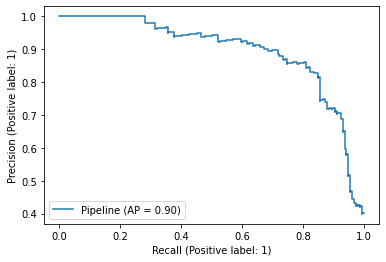

In [164]:
plot_precision_recall_curve(estimator=model_pipeline, X=test_df["comment"], y=test_df["toxic"])

In [165]:
np.where(prec > 0.95)

(array([333, 334, 335, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346,
        347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359,
        360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372,
        373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385,
        386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396], dtype=int64),)

In [166]:
thresholds[374]

0.8522880501870006

In [167]:
precision_score(y_true=test_df["toxic"], y_pred=model_pipeline.predict_proba(test_df["comment"])[:, 1] > thresholds[374])

1.0

In [168]:
recall_score(y_true=test_df["toxic"], y_pred=model_pipeline.predict_proba(test_df["comment"])[:, 1] > thresholds[374])

0.1320754716981132

In [169]:
grid_pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ("model", 
     GridSearchCV(
        LogisticRegression(random_state=0),
        param_grid={'C': [0.1, 1, 10.]},
        cv=3,
         verbose=4
        )
    )
])


In [170]:
grid_pipeline.fit(train_df["comment"], train_df["toxic"])

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV 1/3] END .............................C=0.1;, score=0.687 total time=   0.4s
[CV 2/3] END .............................C=0.1;, score=0.688 total time=   0.2s
[CV 3/3] END .............................C=0.1;, score=0.684 total time=   0.3s
[CV 1/3] END ...............................C=1;, score=0.834 total time=   0.7s
[CV 2/3] END ...............................C=1;, score=0.840 total time=   0.8s
[CV 3/3] END ...............................C=1;, score=0.837 total time=   0.5s


c:\users\ww\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3] END ............................C=10.0;, score=0.860 total time=   1.3s
[CV 2/3] END ............................C=10.0;, score=0.867 total time=   1.3s


c:\users\ww\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3] END ............................C=10.0;, score=0.863 total time=   1.3s


c:\users\ww\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x000002BD093F09D0>)),
                ('model',
                 GridSearchCV(cv=3,
                              estimator=LogisticRegression(random_state=0),
                              param_grid={'C': [0.1, 1, 10.0]}, verbose=4))])

In [171]:
model_pipeline_c_10 = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ("model", LogisticRegression(random_state=0, C=10.))
]
)

In [172]:
model_pipeline_c_10.fit(train_df["comment"], train_df["toxic"])

c:\users\ww\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x000002BD056A8940>)),
                ('model', LogisticRegression(C=10.0, random_state=0))])

In [173]:
prec_c_10, rec_c_10, thresholds_c_10 = precision_recall_curve(y_true=test_df["toxic"], probas_pred=model_pipeline_c_10.predict_proba(test_df["comment"])[:, 1])

In [174]:
np.where(prec_c_10 > 0.95)

(array([326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338,
        339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351,
        352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364,
        365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377,
        378, 379, 380, 381, 382], dtype=int64),)

In [175]:
precision_score(y_true=test_df["toxic"], y_pred=model_pipeline_c_10.predict_proba(test_df["comment"])[:, 1] > thresholds_c_10[316])

0.9384615384615385

In [176]:
recall_score(y_true=test_df["toxic"], y_pred=model_pipeline_c_10.predict_proba(test_df["comment"])[:, 1] > thresholds_c_10[316])

0.3836477987421384